## **Getting the dataset**

Download the dataset and upload in zip file then extract using following code cell

In [ ]:
import os
import zipfile
zip_ref = zipfile.ZipFile("/content/archive.zip", 'r')
zip_ref.extractall('Books')

zip_ref.close()

## **Importing the Libraries**

In [1]:
!pip install plotly==4.0.0

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Read the csv files**

In [3]:
books_data = pd.read_csv('/content/Books/books.csv',error_bad_lines = False)
tags_data = pd.read_csv('/content/Books/tags.csv')
ratings_data = pd.read_csv('/content/Books/ratings.csv')
book_tags = pd.read_csv('/content/Books/book_tags.csv')

In [36]:
books_data.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,The Fault in Our Stars,eng,4.26,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...


In [37]:
tags_data.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [38]:
ratings_data.head()

,book_id,user_id,rating
117889,1180,1,4
488112,4893,1,3
625717,6285,1,4
796318,8034,2,4
875008,8855,2,5


In [39]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


## **Cleaning the data, removing duplicates**
The data provided by the dataset is unclean, and they mention it clearly in the dataset description, if you wish to skip the cleaning process, head on over to the clean data available in the description of the goodbooks dataset. If you like a good challenge, use this one!

In [5]:
ratings_data=ratings_data.sort_values("user_id")
ratings_data.shape

(981756, 3)

In [6]:
ratings_data.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 
ratings_data.shape

(977269, 3)

Therefore, 4487 duplicates were present in the data, that have been removed.

In [7]:
print(books_data.shape)
books_data.drop_duplicates(subset='original_title',keep=False,inplace=True)
print(books_data.shape)

(10000, 23)
(9151, 23)


849 rows removed.

In [8]:
print(tags_data.shape)
tags_data.drop_duplicates(subset='tag_id',keep=False,inplace=True)
print(tags_data.shape)

(34252, 2)
(34252, 2)


No duplicates to remove

In [9]:
print(book_tags.shape)
book_tags.drop_duplicates(subset=['tag_id','goodreads_book_id'],keep=False,inplace=True)
print(book_tags.shape)

(999912, 3)
(999896, 3)


## **Collaborative Filtering**

This data is very messy so dropping null values is crucial.

In [10]:
usecols=['book_id', 'original_title']
books_col=books_data[usecols]

In [11]:
books_col.dropna()

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby
5,11870085,The Fault in Our Stars
...,...,...
9995,7130616,Bayou Moon
9996,208324,Means of Ascent
9997,77431,The Mauritius Command
9998,8565083,Cinderella Ate My Daughter: Dispatches from th...


Creating Compressed sparse row matrix

In [12]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_book_features = ratings_data.pivot(index='book_id',columns='user_id',values='rating').fillna(0)
mat_book_features = csr_matrix(df_book_features.values)

In [13]:
df_book_features.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,53385,53386,53387,53388,53389,53390,53391,53392,53393,53394,53395,53396,53397,53398,53399,53400,53401,53402,53403,53404,53405,53406,53407,53408,53409,53410,53411,53412,53413,53414,53415,53416,53417,53418,53419,53420,53421,53422,53423,53424
book_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, K nearest neighbors algorithm is used to find the nearest book with least distance available.

In [14]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)


num_users = len(ratings_data.user_id.unique())
num_items = len(ratings_data.book_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 53380 unique users and 10000 unique movies in this data set


In [15]:
ratings=ratings_data.dropna()

In [16]:
df_ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp.head(10)

,count
rating,
1,19485
2,63010
3,247698
4,355878
5,291198


In [17]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,532822731
1.0,19485
2.0,63010
3.0,247698
4.0,355878
5.0,291198


After counting all ratings, it is observed that a large amount of books are rated 0 or are unrated. These need to go!

Text(0, 0.5, 'number of ratings')

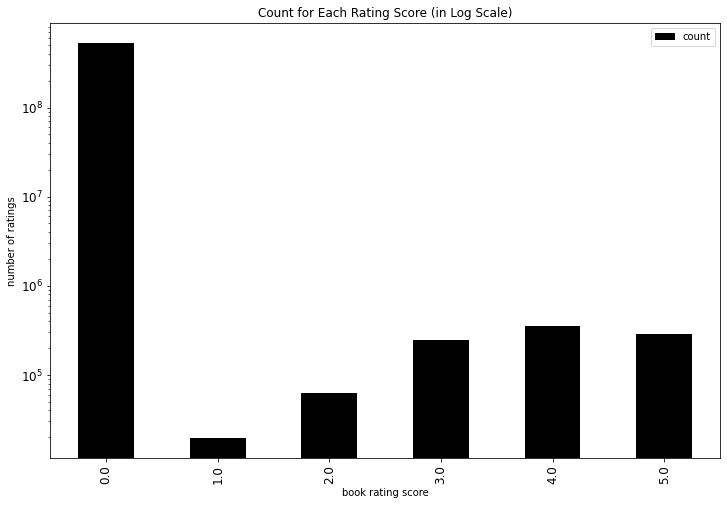

In [18]:
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

import matplotlib.pyplot as plt


get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,color='black'
)
ax.set_xlabel("book rating score")
ax.set_ylabel("number of ratings")

Graph clearly shows that a lot of data is irrevelant and can be removed.

In [19]:
df_books_cnt = pd.DataFrame(ratings.groupby('book_id').size(), columns=['count'])
df_books_cnt.head()

,count
book_id,
1,100
2,100
3,100
4,100
5,100


In [20]:
#now we need to take only books that have been rated atleast 60 times to get some idea of the reactions of users towards it

popularity_thres = 60
popular_movies = list(set(df_books_cnt.query('count >= @popularity_thres').index))
df_ratings_drop = ratings[ratings.book_id.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop.shape)

shape of original ratings data:  (977269, 3)
shape of ratings data after dropping unpopular movies:  (975605, 3)


In [21]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

,count
user_id,
1,3
2,3
3,2
4,3
5,5


Dropping users who have rated less than 50 times

In [22]:
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop[df_ratings_drop.user_id.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (977269, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (417687, 3)


In [23]:
book_user_mat = df_ratings_drop_users.pivot(index='book_id', columns='user_id', values='rating').fillna(0)
book_user_mat

user_id,7,35,41,75,119,143,145,153,158,173,178,202,215,230,244,247,256,274,284,307,314,319,324,341,343,349,363,368,376,377,381,407,424,425,430,439,446,461,491,513,...,53012,53054,53070,53071,53072,53073,53074,53075,53076,53077,53078,53079,53080,53081,53083,53092,53107,53116,53130,53131,53145,53165,53173,53174,53182,53183,53186,53201,53204,53218,53245,53279,53281,53292,53293,53318,53352,53366,53373,53381
book_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
book_user_mat_sparse = csr_matrix(book_user_mat.values)
book_user_mat_sparse

<9886x4892 sparse matrix of type '<class 'numpy.float64'>'
	with 417687 stored elements in Compressed Sparse Row format>

## **Fitting the model**

In [25]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(book_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

Using fuzzy logic to get nearest distance.

The term fuzzy refers to things which are not clear or are vague.In boolean system truth value, 1.0 represents absolute truth value and 0.0 represents absolute false value. But in the fuzzy system, there is no logic for absolute truth and absolute false value. But in fuzzy logic, there is intermediate value too present which is partially true and partially false.

In [26]:
!pip install fuzzywuzzy

In [27]:
from fuzzywuzzy import fuzz


# In[24]:


def fuzzy_matching(mapper, fav_book, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_book.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



Writing the recommendation function.

In [28]:
def make_recommendation(model_knn, data, mapper, fav_book, n_recommendations):
    """
    return top n similar book recommendations based on user's input book
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: book-user matrix
    mapper: dict, map book title name to index of the book in data
    fav_book: str, name of user input book
    n_recommendations: int, top n recommendations
    Return
    ------
    list of top n similar book recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input book:', fav_book)
    idx = fuzzy_matching(mapper, fav_book, verbose=True)
    
    print('Recommendation system starting to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_book))
    rec=[]
    for i, (idx, dist) in enumerate(raw_recommends):
        if idx not in reverse_mapper.keys():
            continue
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
        rec.append(reverse_mapper[idx])
    return rec

Test the above function

In [29]:
my_favorite = 'To Kill a Mockingbird'
indices = pd.Series(books_col.index, index=books_col['original_title'])

In [30]:
make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=indices,
    n_recommendations=10)

You have input book: To Kill a Mockingbird
Found possible matches in our database: ['To Kill a Mockingbird', 'Mockingbird', 'Stolen Songbird']

Recommendation system starting to make inference
......

Recommendations for To Kill a Mockingbird:
1: Lord of the Flies , with distance of 0.45598309432313877
2: Little Women, with distance of 0.4526896099993938
3: Nineteen Eighty-Four, with distance of 0.4396460119625992
4: Memoirs of a Geisha, with distance of 0.43283216907946764
5: Animal Farm: A Fairy Story, with distance of 0.4252435075403517
6: Pride and Prejudice, with distance of 0.4251608152166305
7: Of Mice and Men , with distance of 0.4204446294803902
8: Harry Potter and the Philosopher's Stone, with distance of 0.3892592020883805
9: The Catcher in the Rye, with distance of 0.3699905318987523
10: The Great Gatsby, with distance of 0.2966652339964868


['Lord of the Flies ',
 'Little Women',
 'Nineteen Eighty-Four',
 'Memoirs of a Geisha',
 'Animal Farm: A Fairy Story',
 'Pride and Prejudice',
 'Of Mice and Men ',
 "Harry Potter and the Philosopher's Stone",
 'The Catcher in the Rye',
 'The Great Gatsby']

In [31]:
make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book='Life of Pi',
    mapper=indices,
    n_recommendations=10)

You have input book: Life of Pi
Found possible matches in our database: ['Life of Pi', 'Rise of Empire', 'Life After Life', 'Thief of Time', 'Rules Of Prey']

Recommendation system starting to make inference
......

Recommendations for Life of Pi:
1: Angela's Ashes: A Memoir, with distance of 0.5317611261677895
2: Angels & Demons , with distance of 0.5311350094947309
3: The Time Traveler's Wife, with distance of 0.5229292012456852
4: Harry Potter and the Philosopher's Stone, with distance of 0.5004815076386392
5: Memoirs of a Geisha, with distance of 0.49876077573146493
6: A Thousand Splendid Suns, with distance of 0.4703107747540455
7: The Help, with distance of 0.4656615917412317
8: The Kite Runner , with distance of 0.4600842709185007
9: Water for Elephants, with distance of 0.4554880598843708
10: The Secret Life of Bees, with distance of 0.4409497862929914


["Angela's Ashes: A Memoir",
 'Angels & Demons ',
 "The Time Traveler's Wife",
 "Harry Potter and the Philosopher's Stone",
 'Memoirs of a Geisha',
 'A Thousand Splendid Suns',
 'The Help',
 'The Kite Runner ',
 'Water for Elephants',
 'The Secret Life of Bees']

In [32]:
make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book='Prince of Persia',
    mapper=indices,
    n_recommendations=10)

You have input book: Prince of Persia
Found possible matches in our database: ['Prince of Thorns', 'Prince of Fire', 'Prince of Wolves ', 'Prince of Fools', 'A Princess of Mars', 'Prince Lestat', 'Princess of Glass', 'The Price of Salt', 'Princess on the Brink', 'Princess Mia', 'Prisoner of my desire ', 'Prince of the Blood', 'The Prince of Tides', 'Princess in Pink', 'In One Person', 'Life of Pi', 'Transfer of Power', 'Prison of Ice ', 'Dance of Death', 'Rise of Empire', 'Stone of Tears']

Recommendation system starting to make inference
......

Recommendations for Prince of Persia:
1: The Andromeda Strain, with distance of 0.7675357891599115
2: Sphere, with distance of 0.7336658251699201
3: Congo, with distance of 0.7277253667751804
4: Timeline, with distance of 0.7152011540998453
5: 会長はメイド様! 1, with distance of 0.6954266388438639
6: The Lost World, with distance of 0.6921164623660876
7: Beezus and Ramona, with distance of 0.6419642305695804
8: Prey, with distance of 0.60675685079747

['The Andromeda Strain',
 'Sphere',
 'Congo',
 'Timeline',
 '会長はメイド様! 1',
 'The Lost World',
 'Beezus and Ramona',
 'Prey',
 'State of Fear']